<a href="https://colab.research.google.com/github/helgaholmestad/DSCourse/blob/master/OppgaveDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problemstilling

Tenkt deg at datoen er 29 April 2020. Mange byer i verden begynner å se de aller første tilfellene av coronaviruset, mens i noen byer har pandemien kommet ganske langt allerede. New York er en av byene der pandemien har kommet langt, og de er også gode til å samle inn data. Din oppgave er å lage en modell for å predikere hvilke bydeler som er mest utsatt for å få mange dødsfall fra viruset. Modellen skal andvendes i andre storbyer i verden i det de oppdager sine første koronatilfeller. Meningen er at man skal gå inn og teste mange, samt gjøre andre forebyggende tiltak i bydeler der man predikerer at antall dødsfall kommer til å bli høyt. 

For å evaluere modellen bruker vi leave-one-out cross validation, og vi evaluerer med RMS. Det er skrevet en metode som gjør dette.

### Forklaring til dataene

Alle dataene er oppdatert 28 april 

|Variabel | Forklaring
|--------- | -------------
|deaths | registrerte dødsfall
|cumulative_positives | totalt antall som har testet positivt
|cumulative_tests | totalt antall som er testet
|medianFamily  | median inttekt for en familiy 
|density  | antall personer som bor per km2
|population | befolkning
|smoking   | prosentandel som røyker
|infected  | andel av befolkingen som har blitt syke

### Datakilder
* Antall døde i sentrum av New York per county
https://www1.nyc.gov/site/doh/covid/covid-19-data-archive.page
* Antall døde i hvert county, men flere i sentrum blir telt sammen, dermed ble det kombinert med forrige
https://github.com/nytimes/covid-19-data (Data from The New York Times, based on reports from state and local health agencies.)
* Data om antall testede
https://data.ny.gov/
* Andel som røyker
https://health.data.ny.gov/Health/Community-Health-Indicator-Reports-CHIRS-Latest-Da/54ci-sdfi
* Populasjon og areal av counties
https://www.wolframalpha.com/

## Oppgaven

Vi har skrevet en notebook som tar deg gjennom å utforske dataene, samt lage en modell. 
Ha hele tiden oppgavens problemstilling i bakhode mens du jobber deg gjennom denne notebook

1. Gjør utforskende dataanalyse. Det skal ikke være noe galt med dataene, vi har allerede gått igjennom følgende sjekkliste for å se at alt stemmer: https://docs.google.com/document/d/1km5mnhdYrAO3_2u0B06YSYPQLykuTQmujAuwjQjfAeA/edit?usp=gmail&ts=5e97143a. Det eneste er at vi er på grensen til å ha litt for lite data til å lage en god modell. En slik sjekkliste er veldig nyttig, men noen ganger ikke nok. Det er også viktig å tenke seg godt om når man utforsker dataene og tester ut modeller.
Husk spesielt å:
* Plotte distribusjonene til hver av variablene
* Lag scatterplot for å se på korrelasjon mellom variablene

2. Prøv å sett opp en enkel modell, test linear regresjon og random forest til å begynne med. 
For å evaluere modellen bruker vi leave-one-out cross validation, og vi evaluerer med RMS. Det er skrevet en metode som gjør dette. 








In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import sklearn.feature_selection
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor  

### Importer dataene og få en første oversikt

In [2]:
data=pd.read_csv("newYorkData.csv")
data.head()
data["deaths"]=data["deaths"]

In [3]:
data.shape

(62, 10)

In [4]:
data.describe()

,deaths,cumulative_positives,cumulative_tests,medianFamily,density,infected,smoking,population,arealand
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,6.200000e+01,62.000000
mean,280.403226,4833.725806,14072.274194,63555.225806,1163.960192,0.000097,21.316129,3.125500e+05,1968.653710
std,776.955755,11765.809489,29511.385229,14386.779648,4171.538908,0.000135,5.568271,5.323563e+05,1271.183827
min,0.000000,3.000000,38.000000,38431.000000,1.087230,0.000000,10.400000,4.836000e+03,59.130000
25%,1.000000,59.250000,764.000000,53973.250000,29.024049,0.000002,16.425000,5.124350e+04,1143.500000
50%,3.000000,126.500000,1373.500000,59116.000000,45.864643,0.000039,21.750000,9.130100e+04,1693.000000
75%,29.500000,912.250000,7040.750000,68946.500000,165.366786,0.000120,24.800000,2.310602e+05,2648.000000
max,3608.000000,50741.000000,116488.000000,107934.000000,26820.108236,0.000542,34.300000,2.504700e+06,6942.000000


### Sjekk distribusjonen til hver av variablene
Plott distribusjonen til alle de forskjellige variablene og diskuter det du ser. Bruk upper_lim og lower_lim for å zoome inn på interessante områder

In [5]:
#Hjelpefunksjon for histogrammer
def makeHistogram(data,variable,upper_lim=None,lower_lim=None):
    if upper_lim==None:
        upper_lim=data[variable].max()
    if lower_lim==None:
        lower_lim=data[variable].min()
    plt.hist(data[variable],bins=50,range=[data[variable].min(),upper_lim]) 
    plt.ylabel("frequency")
    plt.xlabel(variable)

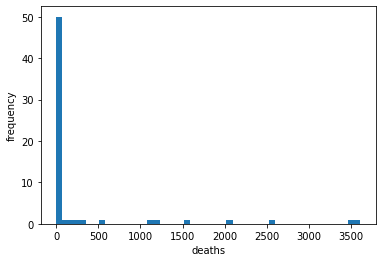

In [6]:
makeHistogram(data,"deaths")

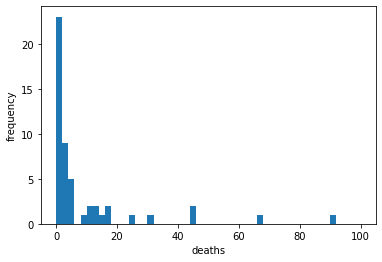

In [7]:
#Zoom in i et mindre område der du tror det er interessant
makeHistogram(data,"deaths",lower_lim=0,upper_lim=100)

### Sjekk korrelasjonen mellom variablene


In [8]:
def corr_heatmap(df, figsize=(10,10)):
    _, axs = plt.subplots(figsize=figsize)
    ax = sns.heatmap(df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True, ax=axs)
    ax.set_title('Correlation matrix')
    return ax

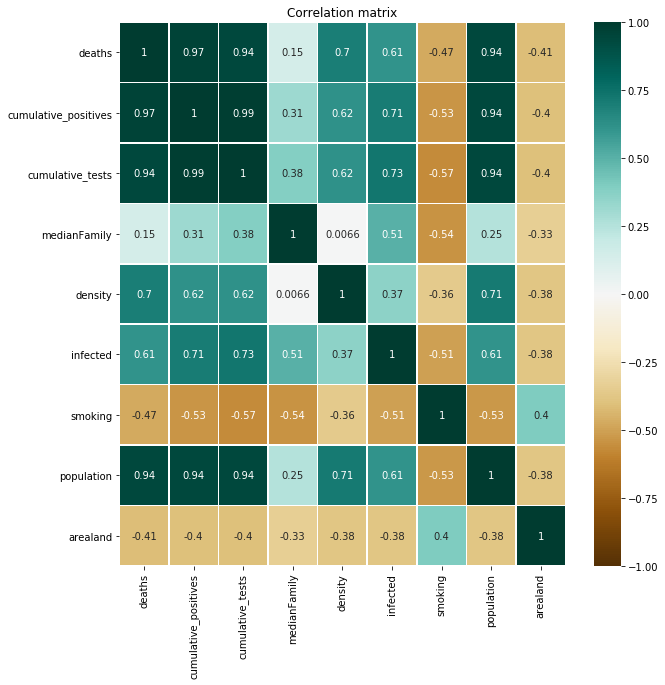

In [9]:
corr_heatmap(data.corr())

Vi ser det er en del sterke korrelasjoner. Sjekk scatterplot for de du mener er interessante, prøv også å bruke log skala. Spesielt ser det ut til at population er korrelert med dødsfall. For hvert scatterplot du lager, tenk igjennom hvorfor det ser ut som det gjør. 

In [10]:
def makeScatterPlot(data,para1,para2,logx=False,logy=False):
    plt.plot(data[para1],data[para2],'*')
    if logx:
        plt.yscale("log")
    if logy:    
        plt.xscale('log')
    plt.xlabel(para1)
    plt.ylabel(para2)

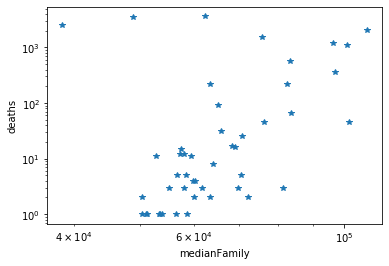

In [11]:
makeScatterPlot(data,"medianFamily","deaths",logx=True, logy=True)

### Diskuter
Det ser ut til at både cumulative_tests, cumulative_ positives, population og density er gode prediktorer. Men allikevel er det ikke sikkert at de bør brukes når man lager en modell. Gå tilbake og les problemstillingen en gang til, diskuter om det er variable vi ikke kan bruke. 

<details> 
  <summary> Trykk på pilen først etter at dere har diskutert </summary>
  Modellen skal brukes i det de første tilfellene dukker opp i en by. På det tidspunktet vet man ikke noe om hvor mange som er smittet, hvor mange som er testet eller hvor mange som har testet positivt. Man ønsker å bruke modellen til å påvirke disse variablene, dermed kan de ikke være en del av modellen
</details>

### Prøv dere frem med noen enkle modeller og diskuter. 

Basert på konklusjonen av diskusjonen i forrige oppgave fokuserer vi på population, medianFamily, smoking og density. Utifra scatter plots ser det ut til at det er en linear sammenheng mellom logaritmen til "deaths" og og logaritmen til en del av variablene. Allikevel kan det være vanskelig å lage en linear modell. Diskuter hva problemen kan være.

<details> 
  <summary> Trykk på pilen først etter at dere har diskutert </summary>
  Dersom du skal transformere dataene slik at du kan lage en lineær modell må du ta logaritmen av kolonnen "deaths". Da blir det et problem at i mange counties er det null dødsfall, og logaritmen til 0 er minus uendelig. Man kan ta hensyn til det, men det er ikke rett frem. Dere kan lese om det her: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3444996. (Jeg har ikke lest hele artikkelen, og lengden på artikkelen gir et intrykk av at dette ikke er rett frem. )    
</details>

Vi tester en enkel random forest modell istedenfor. Random forest er ikke avhenige av lineære sammenhenger. Vi har skrevet en enkel funksjon for dere som gjøre leave-one-out cross validering av modellen. Test modellen med forskjellig kombinasjon av uavhenige variable. Sjekk feature importance. Hvilke features ser ut til å være viktige:

In [12]:
def makePredictions(data,columns):
    regressor = RandomForestRegressor(random_state=4, max_depth=3)
    def predict(train,test):
        test=test[columns]
        X=train[columns]
        y=train["deaths"]
        regressor.fit(X,y)
        prediction=regressor.predict(test)
        return prediction
    predictions=[]
    result=data[columns]
    result["deaths"]=data["deaths"]
    for i in range(len(data)):
        predicted=predict(data.drop([i]),data.iloc[[i]])
        predictions.append(predicted[0])
    result["predictions"]=predictions
    result["diff"]=result["predictions"]-result["deaths"]
    error=np.sqrt(mean_squared_error(result["deaths"],result["predictions"]))
    model=regressor.fit(data[columns],data["deaths"])
    importance=model.feature_importances_
    return result,error,model,importance

In [13]:
columns=["population","density","medianFamily","smoking"]

In [14]:
result,error,model,importance=makePredictions(data,columns)

In [15]:
error

304.9182043807829

In [16]:
importance

array([0.59419438, 0.30407958, 0.04543212, 0.05629392])

<details>
 <summary> Trykk på pilen først etter at dere har prøvd dere frem litt </summary>
Egentlig så ser det ut som om det er best å bruke kun en uavhenige variabel. Dette gir mening, siden det er kun det vi har nok data til. Det ser ut til at "population" er den viktigste variablen
</details>

### La oss ta en tenkepause og diskutere litt igjen

Det ser ut til at den viktigste uavhenige variablen er population. Tenk igjennom hvorfor. Hvilken verdi gir det egentlig for en by å ha en modell som predikerer antall dødsfall som funksjon av antall personer i bydelen? 
Dersom det ikke var noen forskjell på bydelene, hva ville sammenhengen mellom population og deaths da vært? 

Som nevnt i oppgaven så tenker vi oss nå at en annen by skal andvende modellen, men vil modellen slik den er nå gi verdi for den nye byen? Kan vi teste det på noen måte? Diskuter

<details> 
  <summary> Trykk på pilen først etter at dere har diskutert </summary>
    Det er ganske logisk at det er en sammenheng mellom antall folk i en bydel og hvor mange som dør av korona. Dersom alle bydelene har samme risiko, det vil si samme prosentandel som dør, så ville man sett en lineær sammenheng.
    Altså ville man sett en sterk korrelasjon mellom population og deaths selv om alle bydelene var like utsatt. Dersom modellen skal være overførbar til en annen by, burde modellen fungere selv om man valgte å dele inn bydelene på en annen måte. Vi kan gjøre en test ved å slå sammen alle bydelene med mindre enn 70000 inbyggere til en ny bydel, og se hva den modellen predikerer.
    </details>

### Gjør en county sammenslåing (kommunesammenslåing :))

In [17]:
columns=["population"]
result,error,model,importance=makePredictions(data,columns)

In [27]:
small=data[data["population"]<70000]
newCounty=pd.DataFrame()
newCounty=newCounty.append(pd.Series(),ignore_index=True)
newCounty["deaths"]=small["deaths"].sum()
newCounty["density"]=small["population"].sum()/small["arealand"].sum()
newCounty["population"]=small["population"].sum()

In [28]:
newCounty

,deaths,density,population
0,50,21.647068,1166725


In [29]:
model.predict(newCounty[columns])

array([3.02766735e-05])

Dette gikk jo veldig feil. I det nye county så predikerer vi altfor mange dødfall, men det reelle tallet var bare 50. Diskuter hva som skjedde her. 

<details> 
  <summary> Trykk på pilen først etter at dere har diskutert </summary>
Egentlig så bør vi ikke ha med population som en variabel. Fordi det vi egentlig er ute etter er å estimere hvilke bydeler som er mer utsatt for korona enn andre, det vil si hvilke bydeler som har en høyest dødsrate (antall døde per inbygger). Dermed bør vi heller lage en modell der vi predikerer dødsraten. For å evaluere modellen slik vi ble bedt om av oppdragsgiver, estimerer vi dødraten i hver bydel før vi ganger vi med population for å estimere antall som døde. 
    </details>

In [30]:
def makePredictionsUsingDeathRate(data,columns):
    regressor = RandomForestRegressor(n_estimators=200,random_state=42,bootstrap=True,max_depth=3)
    #regressor = DecisionTreeRegressor(max_depth=10)
    def predict(train,test):
        population=test.population.values[0]
        train_population=train["population"]
        test=test[columns]
        X=train[columns]
        y=train["deathRate"]
        regressor.fit(X,y,sample_weight=train_population)
        prediction=regressor.predict(test)
        return prediction[0]*population
    predictions=[]
    result=data[columns]
    result["deaths"]=data["deaths"]
    for i in range(len(data)):
        predicted=predict(data.drop([i]),data.iloc[[i]])
        predictions.append(predicted)
    result["predictions"]=predictions
    result["diff"]=result["predictions"]-result["deaths"]
    error=np.sqrt(mean_squared_error(result["deaths"],result["predictions"]))
    model=regressor.fit(data[columns],data["deathRate"],sample_weight=data["population"])
    importance=model.feature_importances_
    return result,error,model,importance

In [31]:
data["deathRate"]=data["deaths"]/data["population"]

In [32]:
columns=["density"]

In [33]:
result,error,model,importance=makePredictionsUsingDeathRate(data,columns)

In [34]:
error

173.357471470015

In [39]:
#Bruker modellen igjen for å predikere for det nye sammenslåtte county, og nå går det mye bedre
model.predict(newCounty[columns])*newCounty["population"]

0    35.324552
Name: population, dtype: float64

Vi ser at vi fikk en noe bedre modell bare ved å faktisk predikere riktig variabel. Men nå tenker vi på hvert enkel bydel som et målepunkt. Er det riktig å gjøre? Har det noe å si om en bydel har flere inbyggere enn en annen. 

<details> 
  <summary> Trykk på pilen først etter at dere har diskutert </summary>
    I en bydel med stor befolkning har vi flere målepunkter, vi kan tenke på et dødsfall som et målepunkt. Det vil si at vi er mer sikre på dødsraten i en bydel med mange innbyggere. Dermed kan det være lurt å vekte dataene våre med population. Det kan gjøres ved å legge til/forandre to linjer kodei predict.
    <code> train_population=train["population"]#legg til
    regressor.fit(X,y,sample_weight=train_population) #tren med vekting <code>
    </details>

### Hva har vi egentlig endt opp med?

Vi endte opp med en modell som bruker kun density til å predikere death rate. Sidne vi kun har en uavhenige variable kan vi plotte opp modellen.


In [53]:
density=np.arange(data["density"].min(),data["density"].max())
predicted=model.predict(density.reshape(-1,1))

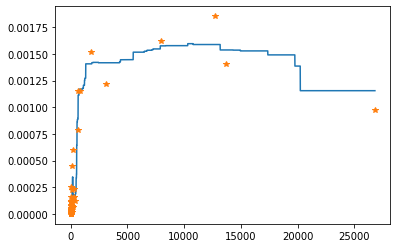

In [54]:
plt.plot(density,predicted)
plt.plot(data["density"],data["deathRate"],'*')

Vi ser at vi egentlig bare har gjort noe som ligner på en enkel kurvetilpasning. Konklusjonen av alt vi har gjort er at tettboddhet gjør en bydel utsastt for korona. Det ser også ut som om vi har en slags terksel, når man kommer over en tetthet på rundt 1000 personer per km^2 så begynner det å bli veldig farlig. Men alt dette kunne vi egentlig ha sett kun ved å plotte density mot deathRate
Ga alt vi gjorde med maskinlæring egentlig noe verdi? Diskuter

<details> 
  <summary> Trykk på pilen først etter at dere har diskutert </summary>
    I prosessen med å lage modellen så lært vi en del nyttig. Selv om konklusjonen vi kom frem til kunne man funnet ved kun å plotte deathRate mot density, så var veien dit lærerik. Det viktigste vi fant ut var at de andre variablene ikke hadde så mye å si. For eksempel hadde det lite å si hvor mange som røyket i bydelen, og hvor rik bydelen var. 
Dersom man ikke hadde gått igjennom prosessen med å lage modellen, så hadde man fremdeles lurt på om disse variablene hadde noe å si. Men ved å lage modellen så ble vi mye sikrere på at tettboddhet er veldig viktig, mye viktigere enn de andre faktorene vi hadde informasjon om. 
    Vi hadde også så lite data at man kun kunne bruke en uavhenige variable for å lage en modell. Gjennom denne prosessen så fant vi ut hvilken variabel som var den viktigste, og vi fant ut at dersom man skal lage en bedre modell trenger man mere data, man må kanskje aggregere data fra flere andre byer
    </details>